# Groverの探索アルゴリズムのシミュレーション

このノートブックでは、量子コンピュータを用いた探索アルゴリズムであるGroverのアルゴリズムについて、テンソルネットワークシミュレーションを試みる。

まずは必要なライブラリをインストールする。

（参考）  
- tensornetworkの公式ドキュメント：  
https://tensornetwork.readthedocs.io/en/latest/index.html

- Qiskitの公式ドキュメント：  
https://qiskit.org/documentation/

In [ ]:
%pip install tensornetwork

In [ ]:
%pip install qiskit

In [ ]:
%pip install pylatexenc

## Groverのアルゴリズム

Groverのアルゴリズムは、$N$個の順序の整理されていないデータの中から、特定のデータを探索するためのアルゴリズムである。

通常、古典コンピュータでは、データを一件ずつ確認していく線形探索が必要であり、計算時間は$O(N)$かかる。  
一方、量子コンピュータにおけるGroverのアルゴリズムでは、$O(\sqrt N)$で計算でき、二乗加速が可能である。

汎用的な探索アルゴリズムであるため、データベースからの探索以外にも、全探索が必要とされるあらゆる場面で活用できることが期待されている。

そのため、組合せ探索のような用途でも活用することができる可能性がある。

一例としては、Qiskitのチュートリアルでは、数独を解くサンプルなどが提示されている。また、ビットコインのマイニング高速化として用いることを提案している論文も存在する。

## 回路の概要

Groverのアルゴリズムは大きく分けて以下の二つの部分から構成される。
- マーキングオラクル
- 振幅増幅

### マーキングオラクル

マーキングオラクルは、探したい対象を特徴づけるための計算である。

具体的には、探したい対象の位相を判定させるような回路のことを指す。

### 振幅増幅

振幅増幅はマーキングオラクルで特徴づけた対象が出現する確率を高めるような計算を行う回路である。  
汎用的な計算の一種であり、Groverのアルゴリズム以外でも用いられる。  

データの件数が多い場合、一度の演算では十分に大きな確率にならないこともあり、マーキングオラクルと振幅増幅を繰り返し用いる必要がある。  
$\sqrt N$程度の回数繰り返すことで、十分に高い確率になることが知られている。  

### 回路の全体像

最初に、すべてのビットにアダマールゲートを作用させ、重ね合わせ状態を作成する。

その後は、マーキングオラクルと振幅増幅の操作を繰り返し適用する。（下図は1回のみのもの）

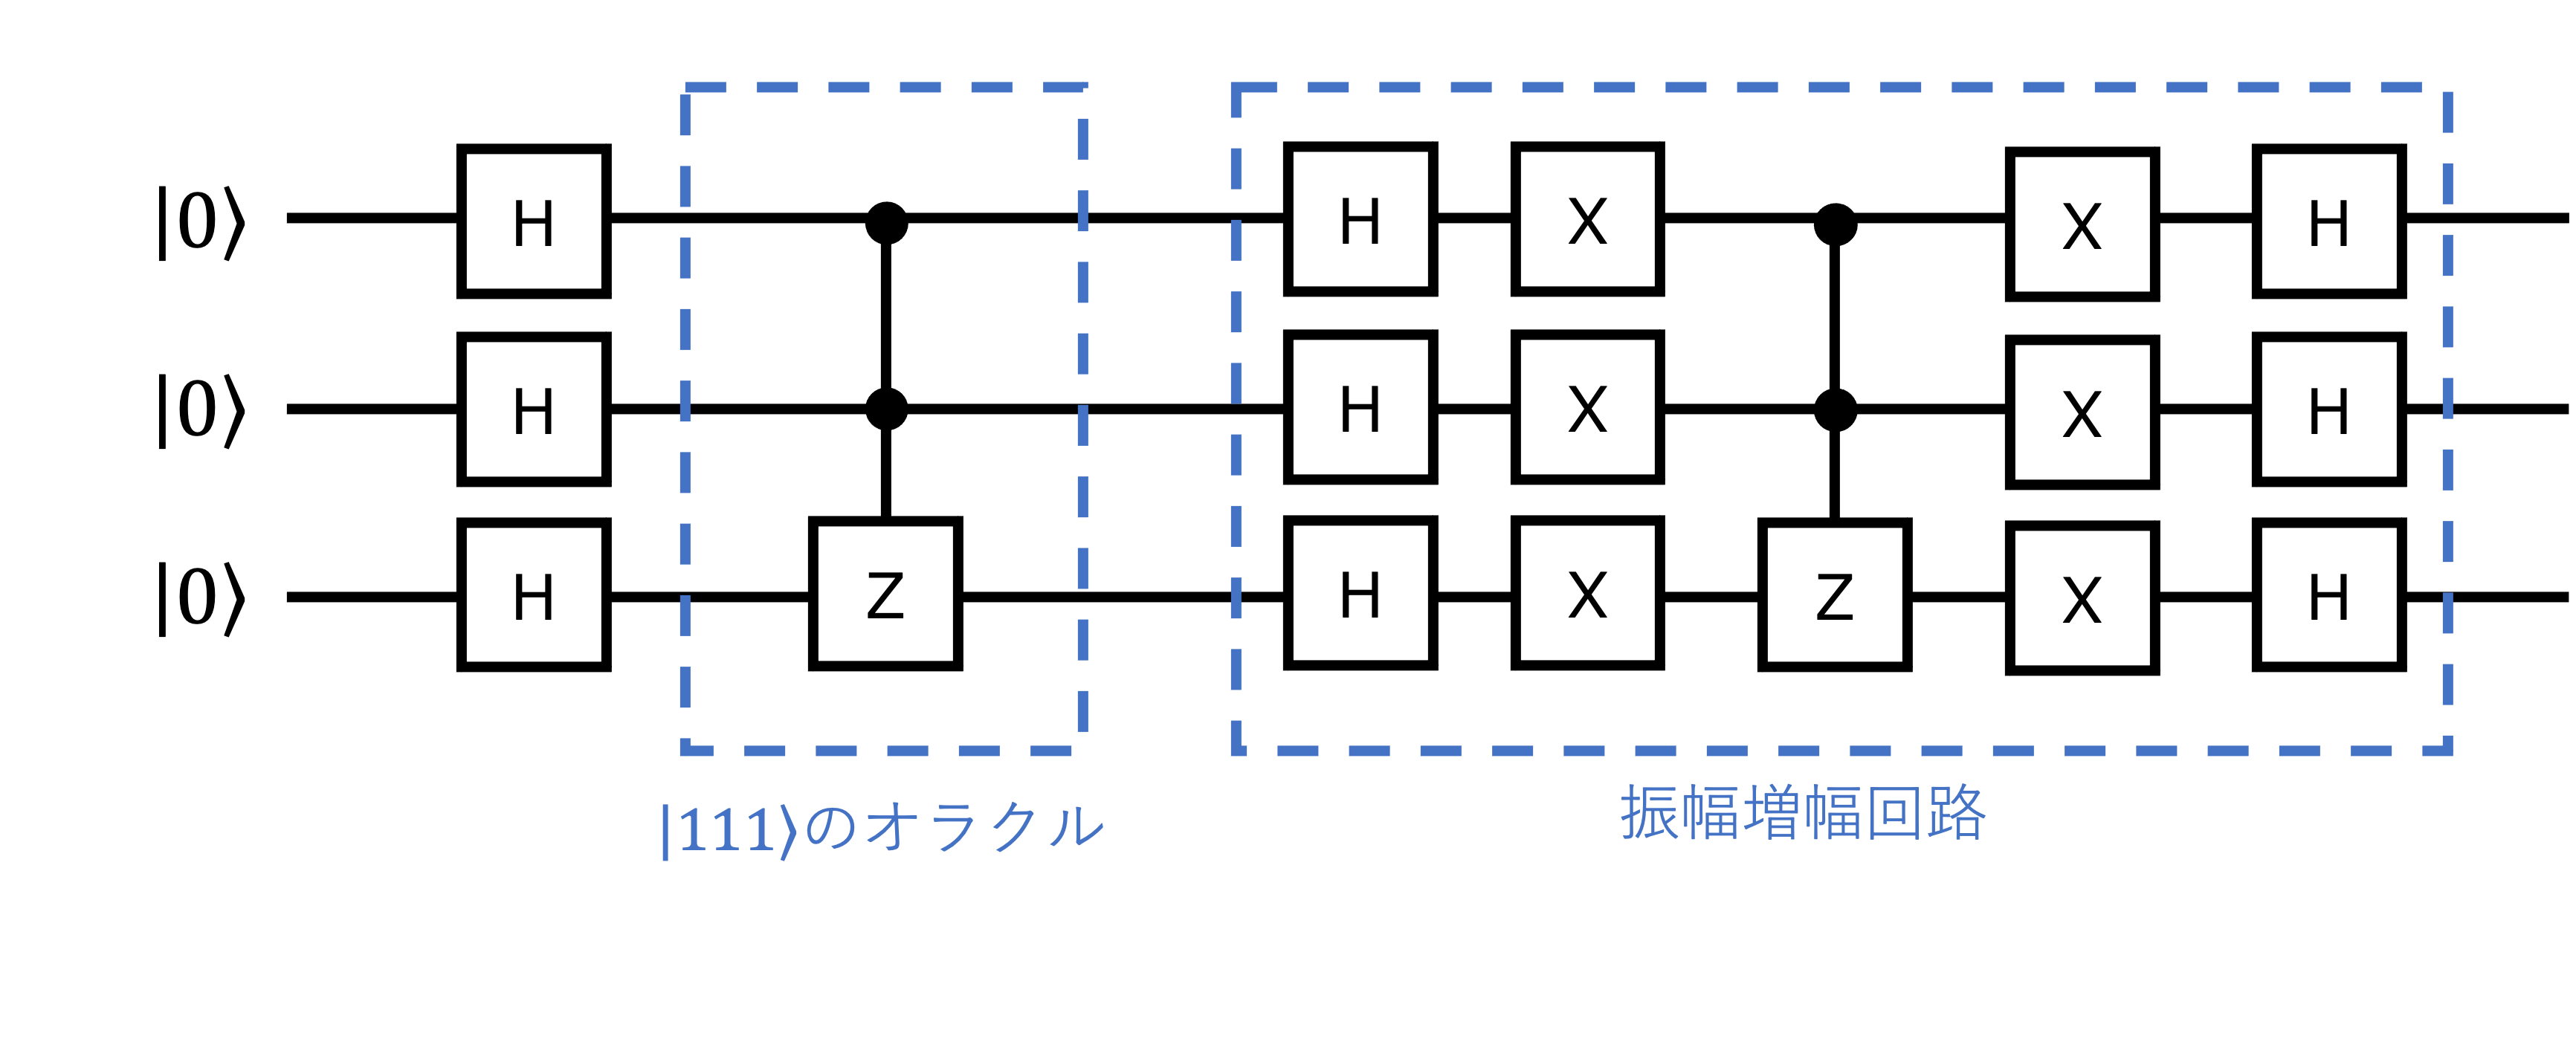

## Qiskitによるシミュレーション

まずは、この回路をQiskit上で実装し、通常のシミュレーション（＝シュレディンガーシミュレーション）を実施してみる。

今回は量子ビット数に関わらず、すべてのビットが1の状態( |11...1> )を探索の対象とする。

In [ ]:
import numpy as np
import qiskit
from qiskit import Aer

In [ ]:
# パラメータ設定
n_qubits = 5  # 量子ビット数
n_amplifiers = 2  # 増幅を行う回数

# 以下は変更不要
backend_sim = Aer.get_backend("qasm_simulator")

Qiskit上ではmulti-controlled Zゲートは実装されていないため、multi-controlled XゲートとHゲートを組み合わせて実装する。

In [ ]:
circ = qiskit.QuantumCircuit(n_qubits, n_qubits)

# input
for i in range(n_qubits):
    circ.h(i)

circ.barrier(range(n_qubits))

# Loop
for _ in range(n_amplifiers):
    # Oracle
    circ.h(n_qubits - 1)
    circ.mct(list(range(n_qubits - 1)), n_qubits - 1)  # マルチ制御トフォリ
    circ.h(n_qubits - 1)

    circ.barrier(range(n_qubits))

    # Amplifier
    for j in range(n_qubits):
        circ.h(j)
        circ.x(j)

    circ.h(n_qubits - 1)
    circ.mct(list(range(n_qubits - 1)), n_qubits - 1)  # マルチ制御トフォリ
    circ.h(n_qubits - 1)

    for j in range(n_qubits):
        circ.x(j)
        circ.h(j)

    circ.barrier(range(n_qubits))

circ.save_statevector()
circ.measure(range(n_qubits), range(n_qubits))

In [ ]:
circ.draw("mpl")

### 観測

シミュレータ上で観測を行い、目的の状態(111...11）が高い確率で観測されることを確認する

In [ ]:
%%time
n_shots = 10000
job_sim = backend_sim.run(qiskit.transpile(circ, backend_sim), shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
statevector = result_sim.get_statevector(circ)

In [ ]:
# 量子ビット数が多く、十分に増幅されていない場合、目的の状態が1度も観測されていないことがある
print(f"観測結果")
if "1" * n_qubits in counts.keys():
    print(f"{'1'*n_qubits}の出現頻度: {counts['1'*n_qubits]}/{n_shots}")
else:
    print(f"{'1'*n_qubits}の出現頻度: {0}/{n_shots}")

print("---------")
print("Statevectorから計算")
print(f"{'1'*n_qubits}の振幅: {statevector[2**n_qubits - 1]}")
print(f"{'1'*n_qubits}の確率: {(statevector[2**n_qubits - 1]**2).real}")

## 課題1

量子ビット数や、増幅回数を変化させながら、アルゴリズムの実行の様子を確認しましょう。  
ビット数を増やしすぎるとメモリエラーになるので気をつけてください。

必要に応じて、ショット数も増やしてください。

---

## テンソルネットワークシミュレーション

multi-controlled Zゲートをそのまま愚直に実装すると、$2^n \times 2^n$サイズの巨大な行列となり、メモリに乗せることができない。  
そのため、今回はmulti-controlled Zゲートを事前に行列積状態に分解しておき、これを用いる。

In [ ]:
import tensornetwork as tn

In [ ]:
# 各種ゲートの定義
h_gate = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

x_gate = np.array([[0, 1], [1, 0]])

# multi controlled Zの材料
L = np.array([[1, 0], [0, 0], [0, 0], [0, 1]])
C = np.array([[[1, 0], [1, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[1, 0], [0, 1]]])
R = np.array([[1, 1], [0, 0], [0, 0], [1, -1]])

In [ ]:
# パラメータ設定
n_qubits = 5  # 量子ビット数
n_amplifiers = 2  # 増幅を行う回数

### ノードの定義

In [ ]:
initial_nodes = []

for _ in range(n_qubits):
    initial_nodes.append(tn.Node(np.array([1, 0])))

In [ ]:
final_nodes = []

for _ in range(n_qubits):
    final_nodes.append(tn.Node(np.array([0, 1])))

In [ ]:
h_nodes = []

for _ in range(n_qubits):
    h_nodes.append(tn.Node(h_gate))

In [ ]:
oracle_nodes = []

for _ in range(n_amplifiers):
    # multi controlled-Z
    oracle_nodes.append(tn.Node(L.reshape(2, 2, 2)))
    for __ in range(n_qubits - 2):
        oracle_nodes.append(tn.Node(C.reshape(2, 2, 2, 2)))
    oracle_nodes.append(tn.Node(R.reshape(2, 2, 2)))

In [ ]:
amplifier_nodes = []

for _ in range(n_amplifiers):
    for __ in range(n_qubits):
        amplifier_nodes.append(tn.Node(h_gate))
        amplifier_nodes.append(tn.Node(x_gate))

    # multi controlled-Z
    amplifier_nodes.append(tn.Node(L.reshape(2, 2, 2)))
    for __ in range(n_qubits - 2):
        amplifier_nodes.append(tn.Node(C.reshape(2, 2, 2, 2)))
    amplifier_nodes.append(tn.Node(R.reshape(2, 2, 2)))

    for __ in range(n_qubits):
        amplifier_nodes.append(tn.Node(x_gate))
        amplifier_nodes.append(tn.Node(h_gate))

### エッジの定義

In [ ]:
# initial_nodes -> h_nodes
for i in range(n_qubits):
    tn.connect(initial_nodes[i][0], h_nodes[i][0])

In [ ]:
# h_nodes -> first_oracle_nodes
for i in range(n_qubits):
    tn.connect(h_nodes[i][1], oracle_nodes[i][0])

In [ ]:
# in oracle_nodes

for i in range(n_amplifiers):
    # L - C  (n_qubits = 2のときはL - R)
    tn.connect(oracle_nodes[i * n_qubits + 0][2], oracle_nodes[i * n_qubits + 1][2])

    # C - R
    if n_qubits != 2:
        tn.connect(oracle_nodes[i * n_qubits + (n_qubits - 2)][3], oracle_nodes[i * n_qubits + (n_qubits - 1)][2])

    # C - C
    for j in range(1, n_qubits - 2):
        tn.connect(oracle_nodes[i * n_qubits + j][3], oracle_nodes[i * n_qubits + (j + 1)][2])

In [ ]:
# oracle_nodes -> amplifier_nodes
for i in range(n_amplifiers):
    for j in range(n_qubits):
        tn.connect(oracle_nodes[i * n_qubits + j][1], amplifier_nodes[i * (5 * n_qubits) + 2 * j][0])

In [ ]:
# in amplifier_nodes
for i in range(n_amplifiers):
    for j in range(n_qubits):
        # h -> x
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 2 * j][1], amplifier_nodes[i * (5 * n_qubits) + 2 * j + 1][0])
        
        # x -> mcz
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 2 * j + 1][1], 
                   amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + j][0])

        # mcz -> x
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + j][1], 
                   amplifier_nodes[i * (5 * n_qubits) + 3 * n_qubits + 2 * j][0])
        
        # x -> h
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 3 * n_qubits + 2 * j][1], 
                   amplifier_nodes[i * (5 * n_qubits) + 3 * n_qubits + 2 * j + 1][0])
        
    # in mcz
    # L - C
    tn.connect(amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + 0][2],
               amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + 1][2])
    
    # C - R
    if n_qubits != 2:
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + (n_qubits - 2)][3], 
                   amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + (n_qubits - 1)][2])

    # C - C
    for j in range(1, n_qubits - 2):
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + j][3],
                   amplifier_nodes[i * (5 * n_qubits) + 2 * n_qubits + (j + 1)][2])

In [ ]:
# amplifier_nodes -> oracle nodes (except final layer)
for i in range(n_amplifiers - 1):
    for j in range(n_qubits):
        tn.connect(amplifier_nodes[i * (5 * n_qubits) + 3 * n_qubits + 2 * j + 1][1],
                   oracle_nodes[(i + 1) * n_qubits + j][0])

In [ ]:
# last_amplifier_nodes -> final_nodes
for i in range(n_qubits):
    tn.connect(amplifier_nodes[(n_amplifiers - 1) * (5 * n_qubits) + 3 * n_qubits + 2 * i + 1][1],
               final_nodes[i][0])

### 縮約計算

最後に縮約を取ることで、求めたかった状態の確率が確認できる

In [ ]:
%%time
nodes = initial_nodes + h_nodes + oracle_nodes + amplifier_nodes + final_nodes

result = tn.contractors.auto(nodes=nodes)

In [ ]:
print(f"確率：{result.tensor**2}")

## 課題2

量子ビット数や、増幅回数を変化させながら、アルゴリズムの実行の様子を確認し、Qiskitでのシミュレーション結果と一致することを確認しましょう。

## 課題3

量子ビット数や、増幅回数に対して、計算時間がどのように変化していくかを確認し、計算時間との関係について考えてみましょう。

Qiskitでは動かないような量子ビット数でも実験してみてください。

---

以下は、時間が余った人は動かしてみてください。

### (参考) テンソルネットワークを用いたサンプリング

今回の講義中では、詳細は取り扱わないが、テンソルネットワークを用いて、サンプリングを行う手法も存在する。

QiskitのMPSシミュレーターを用いることで、その性能を簡単に体験することができる。

In [ ]:
from qiskit.providers.aer import AerSimulator

MPS_sim = AerSimulator(method="matrix_product_state")

In [ ]:
%%time
n_shots = 10000
job_sim = MPS_sim.run(qiskit.transpile(circ, MPS_sim), shots=n_shots) # シミュレーターを変更
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)

In [ ]:
# 量子ビット数が多く、十分に増幅されていない場合、目的の状態が1度も観測されていないことがある
print(f"観測結果")
if "1" * n_qubits in counts.keys():
    print(f"{'1'*n_qubits}の出現頻度: {counts['1'*n_qubits]}/{n_shots}")
else:
    print(f"{'1'*n_qubits}の出現頻度: {0}/{n_shots}")

また、ボンド次元を制限することで、近似を取り込み、メモリ使用量や計算時間を抑えることができる。

ただし、近似を入れたことにより、出力は変化する。

In [ ]:
# ボンド次元を2に制限
MPS_sim_dim2 = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=2)

In [ ]:
%%time
n_shots = 10000
job_sim = MPS_sim_dim2.run(qiskit.transpile(circ, MPS_sim_dim2), shots=n_shots)  # シミュレーターを変更
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)

In [ ]:
# 量子ビット数が多く、十分に増幅されていない場合、目的の状態が1度も観測されていないことがある
print(f"観測結果")
if "1" * n_qubits in counts.keys():
    print(f"{'1'*n_qubits}の出現頻度: {counts['1'*n_qubits]}/{n_shots}")
else:
    print(f"{'1'*n_qubits}の出現頻度: {0}/{n_shots}")